In [6]:
# !pip install dgl
# !pip install seaborn
# !pip install nbimporter

In [9]:
import os
import dgl
import numpy as np
import networkx as nx
import torch as T
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn
from dgl.nn.pytorch import GraphConv
from dgl.nn import SAGEConv

import itertools
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from torch.autograd import Variable
from ipykernel import kernelapp as app
import scipy.stats as stats
import pylab as pl
from scipy.stats import norm
import statistics
import numpy.linalg as LA

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import time
import seaborn as sns
import matplotlib.patheffects as PathEffects
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,rc={"lines.linewidth": 2.5})

import nbimporter
from NDE_Time_Series_Problem import fashion_scatter
from Proof_of_Concept_KG import my_agg_func,my_conc_func

from onai.ml.tools.spark import get_spark
spark = get_spark()

# %store -r Six_digit_NAICS
# %store -r CapIQ_data_dict_FY_N


In [10]:
def spark_load(spark,p,extra_options = None,persist = False,temp_view_name= None):
    
    fmt, remained_p = p.split("://", 1)
    reader = spark.read
    if extra_options:
        reader = reader.options(**extra_options)
    if fmt in SUPPORTED_FMT_LIST:
        reader = reader.format(fmt)
        p = remained_p
    res_df = reader.load(p)
    if persist:
        res_df = res_df.persist()
    if temp_view_name is not None:
        res_df.createOrReplaceTempView(temp_view_name)
        
    return res_df

SUPPORTED_FMT_LIST = {'orc', 'parquet', 'csv'}

In [11]:
df = spark.read.parquet("s3://one-lake-prod/business/company_data_denormalized/")
df.createOrReplaceTempView('cdd')

variable = 100
query = "select entity_id from cdd limit {}".format(100)
df = spark.sql(query)
pdf = df.toPandas()
pdf.head()

,entity_id
0,000014d2-e7ed-5082-a206-c3793a6b9e10
1,00001d05-ef01-55c6-ae7c-eac5b29cafd7
2,00002f21-312a-59aa-90d0-263621590131
3,000056a3-62a1-52ab-b31a-99be52a19452
4,000057e4-4f57-5876-a04d-06a35acc55a2


In [13]:
business_dir = 's3://one-lake-prod/ml-snapshots/20220327/business'

spark_load(spark, os.path.join(business_dir, 'financial_data'), temp_view_name='fd')
spark_load(spark, os.path.join(business_dir, 'company_data_denormalized'), temp_view_name='cdd')
spark_load(spark, os.path.join(business_dir, 'exchange_rate'), temp_view_name='er')
spark_load(spark, os.path.join(business_dir, 'company_data'), temp_view_name='cd')

spark_load(spark, 'csv://' + os.path.join(business_dir, 'dime_map', 'dime.csv'), 
           dict(header='True', inferSchema='True', delimiter=','), temp_view_name='dm')


DataFrame[oneid: string, mnemonic: string, provider_name: string, provider_data_item_id: string, name: string, accounting_concept_code: string, is_symbol: boolean, is_monetary: boolean, is_fiscal: boolean, is_array: boolean, value_type: string, description: string]

In [14]:
query = """select cdd.entity_id,cdd.primary_naics_node,dm.mnemonic,event_date, fd.data_value from fd 
        join dm on dm.oneid = fd.data_item_id
        join cdd on cdd.entity_id = fd.entity_id
        where dm.mnemonic in ('TOTAL_REVENUE','AGR_REV')
        and fd.period_type = 'ANNUAL'
        and dm.provider_name = 'CapitalIQ'
        and cdd.country_of_incorporation_iso = 'USA'
        order by entity_id, fd.event_date desc
        """

df = spark.sql(query)
data = df.toPandas()
data.head()

,entity_id,primary_naics_node,mnemonic,event_date,data_value
0,000028f8-80c2-57c2-a20e-4ad50d2417b4,335312,AGR_REV,2015-12-31,"{""value"": -40.7765}"
1,000028f8-80c2-57c2-a20e-4ad50d2417b4,335312,TOTAL_REVENUE,2015-12-31,"{""value"": 6880.0, ""currency"": ""USD""}"
2,000028f8-80c2-57c2-a20e-4ad50d2417b4,335312,AGR_REV,2014-12-31,"{""value"": -8.0789}"
3,000028f8-80c2-57c2-a20e-4ad50d2417b4,335312,TOTAL_REVENUE,2014-12-31,"{""value"": 11617.0, ""currency"": ""USD""}"
4,000028f8-80c2-57c2-a20e-4ad50d2417b4,335312,TOTAL_REVENUE,2013-12-31,"{""value"": 12638.0, ""currency"": ""USD""}"


In [15]:
print(len(data))

1847069


In [16]:
def Pandas_to_Dict(sector_data):
    
    Dict = {}
    for i in range(len(sector_data)):
        if sector_data.loc[i,"entity_id"] in Dict.keys():
            year,_,_ = sector_data.loc[i,"event_date"].split('-')
        
            if sector_data.loc[i,"mnemonic"] == 'TOTAL_REVENUE':
                if year not in Dict[sector_data.loc[i,"entity_id"]]['R_Time']:
                    val,_ = sector_data.loc[i,"data_value"].split(',')
                    _,val = val.split(':')
                    if 'E' in val:
                        val,p = val.split("E")
                        val = float(val)*(10**int(p))
                        val = int(val)
                    else:
                        val,_ = val.split('.')
                        val = int(val)
                    Dict[sector_data.loc[i,"entity_id"]]['Revenue'].append((year,val))
                    Dict[sector_data.loc[i,"entity_id"]]['R_Time'].append(year)
                
            elif sector_data.loc[i,"mnemonic"] == 'AGR_REV':
                if year not in Dict[sector_data.loc[i,"entity_id"]]['G_Time']:
                    _,val = sector_data.loc[i,"data_value"].split(':')

                    Dict[sector_data.loc[i,"entity_id"]]['AGR_REV'].append((year,float(val[:-1])))
                    Dict[sector_data.loc[i,"entity_id"]]['G_Time'].append(year)

        else:
            Dict[sector_data.loc[i,"entity_id"]] = {'sector' : sector_data.loc[i,"primary_naics_node"], 'Revenue' : [],
                                                   'AGR_REV' : [], 'R_Time' : [], 'G_Time' : []}
        
    return Dict
    

In [17]:
Data_Dict = Pandas_to_Dict(data)

print(len(Data_Dict))

n = 0
for i in Data_Dict.items():
    print(i,"\n")
    n += 1
    if n == 3:
        break

199117
('000028f8-80c2-57c2-a20e-4ad50d2417b4', {'sector': '335312', 'Revenue': [('2015', 6880), ('2014', 11617), ('2013', 12638), ('2011', 1291443), ('2010', 4658056), ('2006', 1628519), ('2005', 1628519)], 'AGR_REV': [('2014', -8.0789), ('2006', 0.0)], 'R_Time': ['2015', '2014', '2013', '2011', '2010', '2006', '2005'], 'G_Time': ['2014', '2006']}) 

('000064e3-2f41-5949-8ee6-e5c1221d3a55', {'sector': None, 'Revenue': [('2019', 765736), ('2018', 808586), ('2016', 16259663), ('2015', 15125431), ('2014', 706437), ('2008', 550553)], 'AGR_REV': [('2016', 7.4988), ('2015', 2041.087)], 'R_Time': ['2019', '2018', '2016', '2015', '2014', '2008'], 'G_Time': ['2016', '2015']}) 

('00007d99-494a-5831-be00-5dd053b3763e', {'sector': '621610', 'Revenue': [('2017', 3940070), ('2016', 4716616), ('2014', 5272323), ('2009', 14196)], 'AGR_REV': [], 'R_Time': ['2017', '2016', '2014', '2009'], 'G_Time': []}) 



In [18]:
def Filter_1(Data_Dict):
    l = []
    for i in Data_Dict.items():
        ID,INFO = i
        if len(INFO['Revenue']) < 5 or len(INFO['AGR_REV']) < 5:
            l.append(ID)


    for i in l:
        Data_Dict.pop(i)
        
    return Data_Dict

Data_Dict = Filter_1(Data_Dict)

print("Length of Data Dict ",len(Data_Dict))
n = 0
for i in Data_Dict.items():
    print(i,"\n")
    n += 1
    if n == 3:
        break

Length of Data Dict  37056
('00023c5a-004b-53a9-b57f-fca73cca257f', {'sector': '721110', 'Revenue': [('2004', 84509633), ('2003', 37616184), ('2002', 36464349), ('2001', 41531051), ('2000', 42262957), ('1999', 34668532), ('1998', 18229748), ('1997', 12966184), ('1996', 9376101), ('1995', 6342229), ('1994', 3972976)], 'AGR_REV': [('2005', 7.5136), ('2004', 125.3929), ('2003', 3.1825), ('2002', -12.0121), ('2001', -1.7318), ('2000', 21.9058), ('1999', 90.1755), ('1998', 40.5945), ('1997', 38.2897), ('1996', 47.836), ('1995', 59.6342)], 'R_Time': ['2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995', '1994'], 'G_Time': ['2005', '2004', '2003', '2002', '2001', '2000', '1999', '1998', '1997', '1996', '1995']}) 

('0004b29e-62ba-5f86-b3d5-4dcf0bd553b1', {'sector': '423310', 'Revenue': [('2021', 937800000), ('2020', 792300000), ('2019', 811999999), ('2018', 839600000), ('2017', 753200000), ('2016', 713900000), ('2015', 659600000), ('2014', 623700000), ('2013', 561500

In [2467]:
def Filter_2(Data_Dict,time_frame):
    
    FYear_Data_Dict = {}
    for i in Data_Dict.items():
        ID,data = i
        FYear_Data_Dict[ID] = {}
        FYear_Data_Dict[ID]['Sector'] = data['sector']
        FYear_Data_Dict[ID]['Revenue'] = data['Revenue'][:20][::-1]

    l = []
    Time_Dict = {}
    for i in FYear_Data_Dict.items():
        ID,data = i

        R_time = []
        for j in data['Revenue']:
            R_time.append(j[0])

#         E_time = []
#         for j in data['AGR_REV']:
#             E_time.append(j[0])


        lis = list(set(R_time))
        lis.sort()
        Time_Dict[ID] = lis
        

    l = []
    for i in Time_Dict.items():
        ID,time = i
        if len(time) < len(time_frame):
            l.append(ID)

    for i in l:
        Time_Dict.pop(i)


    Five_Year_Data_Dict = {}
    for i in Time_Dict.items():
        ID,time = i
        if time[-(len(time_frame)+1):-1] == time_frame:
            data = FYear_Data_Dict[ID]
            Five_Year_Data_Dict[ID] = {}
            Five_Year_Data_Dict[ID]['Sector'] = data['Sector']
            Five_Year_Data_Dict[ID]['Time'] = time[-(len(time_frame)+1):-1]

            Five_Year_Data_Dict[ID]['R'] = []

            for j in time[-(len(time_frame)+1):-1]:
                for p in data['Revenue']:
                    if j == p[0]:
                        Five_Year_Data_Dict[ID]['R'].append(p[1])



    return Five_Year_Data_Dict

#'2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019'
time_frame = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
Six_Year_Data_Dict = Filter_2(Data_Dict,time_frame)
print("Length of Data Dict ",len(Six_Year_Data_Dict))
n = 0
for i in Six_Year_Data_Dict.items():
    print(i,"\n")
    n += 1
    if n == 3:
        break

Length of Data Dict  1836
('00957ff2-70ba-591c-a637-e3cac7c95700', {'Sector': '5231', 'Time': ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 'R': [191419000, 314475000, 376541000, 529758000, 648028000, 762565000, 920110000, 1228989000, 1427410000, 1635517000, 2063425000, 1983975000]}) 

('00b73410-3781-517c-8da2-982e215fb6bd', {'Sector': '237130', 'Time': ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 'R': [1378663000, 1623502000, 2143024000, 2831292000, 3726789000, 4324787000, 4611803000, 4208330000, 5134703000, 6606978000, 6909417000, 7183188000]}) 

('00e0230e-245c-5678-b45d-4d565ee298c0', {'Sector': '33221', 'Time': ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 'R': [487934999, 415040000, 443171000, 444418000, 486842000, 502721000, 586010000, 587670000, 592619000, 579476000, 704542000, 734902000]}) 



('522120', 31)
('624190', 32)
('2211', 39)
('511210', 59)
('522110', 189)


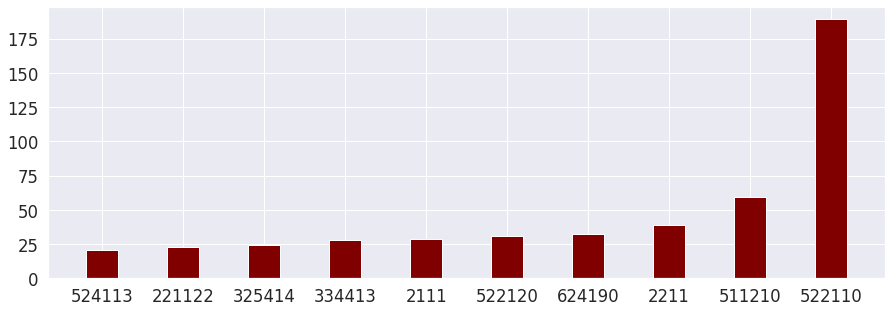

In [2468]:
S = {}
for i in Six_Year_Data_Dict.items():
    ID,data = i

    if data['Sector'] in S.keys():
        S[data['Sector']] += 1
    else:
        if data['Sector'] != None:
            S[data['Sector']] = 1
        
    

S = {k: v for k, v in sorted(S.items(), key=lambda item: item[1])}
for i in list(S.items())[-5:]:
    print(i)

plt.figure(figsize = (15,5))
plt.bar(list(S.keys())[-10:], list(S.values())[-10:], color ='maroon',width = 0.4)
plt.show()

In [2469]:
def Get_Growth_Rate(Six_Year_Data_Dict):
    
    global GR_Lower_limit
    GR_Lower_limit = 0
    Data_Dict = {}
    L = set()
    for i in Six_Year_Data_Dict.items():
        ID,data = i
        f = 0
        for j in data['R']:
            if j == 0:
                f = 1
        if f == 0:   
            Data_Dict[ID] = data
            Data_Dict[ID]['GR'] = []
            for i in range(len(data['R']) - 1):
                gr = round((data['R'][i+1] - data['R'][i])/data['R'][i],3)
                if gr > 1:
                    gr = 1
                elif gr <= -1:
                    gr = -1
                    
#                 if 0 < gr < 0.01:
#                     gr = 0.01
#                 elif -0.01 < gr < 0:
#                     gr = -0.01
                Data_Dict[ID]['GR'].append(round(gr,4))
            
#             if np.sum(Data_Dict[ID]['GR'][:6]) < 0.05:
#                 L.add(ID)
                
#     for i in list(L):
#         Data_Dict.pop(i)
        
    return Data_Dict

Six_Year_Data_Dict_withGR = Get_Growth_Rate(Six_Year_Data_Dict)
print("Length of Data Dict ",len(Six_Year_Data_Dict_withGR))
n = 0
for i in Six_Year_Data_Dict_withGR.items():
    print(i,"\n")
    n += 1
    if n == 3:
        break
        

Length of Data Dict  1836
('00957ff2-70ba-591c-a637-e3cac7c95700', {'Sector': '5231', 'Time': ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 'R': [191419000, 314475000, 376541000, 529758000, 648028000, 762565000, 920110000, 1228989000, 1427410000, 1635517000, 2063425000, 1983975000], 'GR': [0.643, 0.197, 0.407, 0.223, 0.177, 0.207, 0.336, 0.161, 0.146, 0.262, -0.039]}) 

('00b73410-3781-517c-8da2-982e215fb6bd', {'Sector': '237130', 'Time': ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 'R': [1378663000, 1623502000, 2143024000, 2831292000, 3726789000, 4324787000, 4611803000, 4208330000, 5134703000, 6606978000, 6909417000, 7183188000], 'GR': [0.178, 0.32, 0.321, 0.316, 0.16, 0.066, -0.087, 0.22, 0.287, 0.046, 0.04]}) 

('00e0230e-245c-5678-b45d-4d565ee298c0', {'Sector': '33221', 'Time': ['2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019'], 'R':

In [2470]:
def Data_Set_Normalised(Data_Set):
    decimal = 3
    Data_Set_N = {}
    
    for i in Data_Set.items():
        ID,data = i
        
        Data_Set_N[ID] = {'Sector': data['Sector']}
        
        Data_Set_N[ID].update({'Revenue' : []})
        for j in data['R'][1:]:
            if j < 0:
                Data_Set_N[ID]['Revenue'].append(0)
            elif j in range(0,5000000):
                Data_Set_N[ID]['Revenue'].append(round((0.0 + (j)/50000000),decimal))
            elif j in range(5000000,10000000):
                Data_Set_N[ID]['Revenue'].append(round((0.1 + (j-5000000)/50000000),decimal))
            elif j in range(10000000,50000000):
                Data_Set_N[ID]['Revenue'].append(round((0.2 + (j)/500000000),decimal))
            elif j in range(50000000,100000000):
                Data_Set_N[ID]['Revenue'].append(round((0.3 + (j-50000000)/500000000),decimal))
            elif j in range(100000000,500000000):
                Data_Set_N[ID]['Revenue'].append(round((0.4 + (j)/5000000000),decimal))
            elif j in range(500000000,1000000000):
                Data_Set_N[ID]['Revenue'].append(round((0.5 + (j-500000000)/5000000000),decimal))
            elif j in range(1000000000,5000000000):
                Data_Set_N[ID]['Revenue'].append(round((0.6 + (j)/50000000000),decimal))
            elif j in range(5000000000,10000000000):
                Data_Set_N[ID]['Revenue'].append(round((0.7 + (j-5000000000)/50000000000),decimal))
            elif j in range(10000000000,50000000000):
                Data_Set_N[ID]['Revenue'].append(round((0.8 + (j)/500000000000),decimal))
            elif j > 50000000000:
                Data_Set_N[ID]['Revenue'].append(1)
                
        Data_Set_N[ID]['GR'] = data['GR']
                
                
    return Data_Set_N

Six_Year_Data_Dict_withGR_N = Data_Set_Normalised(Six_Year_Data_Dict_withGR)
n = 0
for i in Six_Year_Data_Dict_withGR_N.items():
    print(i,"\n")
    n += 1
    if n == 3:
        break

('00957ff2-70ba-591c-a637-e3cac7c95700', {'Sector': '5231', 'Revenue': [0.463, 0.475, 0.506, 0.53, 0.553, 0.584, 0.625, 0.629, 0.633, 0.641, 0.64], 'GR': [0.643, 0.197, 0.407, 0.223, 0.177, 0.207, 0.336, 0.161, 0.146, 0.262, -0.039]}) 

('00b73410-3781-517c-8da2-982e215fb6bd', {'Sector': '237130', 'Revenue': [0.632, 0.643, 0.657, 0.675, 0.686, 0.692, 0.684, 0.703, 0.732, 0.738, 0.744], 'GR': [0.178, 0.32, 0.321, 0.316, 0.16, 0.066, -0.087, 0.22, 0.287, 0.046, 0.04]}) 

('00e0230e-245c-5678-b45d-4d565ee298c0', {'Sector': '33221', 'Revenue': [0.483, 0.489, 0.489, 0.497, 0.501, 0.517, 0.518, 0.519, 0.516, 0.541, 0.547], 'GR': [-0.149, 0.068, 0.003, 0.095, 0.033, 0.166, 0.003, 0.008, -0.022, 0.216, 0.043]}) 



In [2537]:
Five_Year_Data_Set_N = {}
sector = '2211'
for i in Six_Year_Data_Dict_withGR_N.items():
    ID,data = i
    f = 0
    if data['Sector'] == sector:
        Five_Year_Data_Set_N[ID] = data
    
print(len(Five_Year_Data_Set_N))
n = 0
for i in Five_Year_Data_Set_N.items():
    ID,data = i
#     print(data['GR'][10],"\n")
#     if n == 3:
#         break
#     n+=1


39


In [2538]:
def build_borrower_sector_graph(Data_Set):
    
    n_borrowers = len(Data_Set.keys())
    
    sector_list = set()
    for i in Data_Set.items():
        ID,data = i
        sector_list.add(data['Sector'])
    print(sector_list)
    sector_list = list(sector_list)
    n_sectors = len(sector_list)
    
    b_s_dst = []
    for i in Data_Set.items():
        ID,data = i
        b_s_dst.append(sector_list.index(data['Sector']))
    
    b_s_src = T.arange(n_borrowers,dtype=T.int64)
    b_s_dst = T.tensor(b_s_dst,dtype=T.int64)

    
    
    data_dict = {
    ('L1', 'fin1', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('L2', 'fin2', 'borrower' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    ('R', 'R_att', 'L1' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
    ('GR', 'GR_att', 'L2' ):(T.arange(n_borrowers), T.arange(n_borrowers)),
        
    }

    return dgl.heterograph(data_dict),n_borrowers,n_sectors, b_s_dst

G, n_borrowers, n_sectors, sector_list = build_borrower_sector_graph(Five_Year_Data_Set_N)
print("No.of Borrowers ", n_borrowers, " No.of Sectors ", n_sectors)
%store sector_list


{'2211'}
No.of Borrowers  39  No.of Sectors  1
Stored 'sector_list' (Tensor)


In [2539]:
def Loss_Function(embeddings, target_centers, centers, kmeans_labels):
    
    a = T.mean(T.sqrt(T.sum((embeddings - target_centers)**2,1)))
    
    
    next_target = []
    for i in range(len(embeddings)):

        cluster = target_centers[i]
        
        if len(centers) != 1: 
            dist = []
            C = []
            for m in centers:
                d = np.square(embeddings.detach().numpy()[i] - m.detach().numpy()).mean()
                dist.append(d)
                C.append(m)
                
            
            tup = list(zip(dist,C))
            lst = len(tup) 
            for i in range(0, lst): 

                for j in range(0, lst-i-1): 
                    if (tup[j][0] > tup[j + 1][0]): 
                        temp = tup[j] 
                        tup[j]= tup[j + 1] 
                        tup[j + 1]= temp
            
            next_c = tup[1][1]
        else:
            next_c = centers[0]
            
        
        next_target.append(next_c.detach().numpy())
    
    next_target = T.tensor(next_target)
    
    b = T.mean(T.sqrt(T.sum((embeddings - next_target)**2,1)))
    
    
    return (a - b)/T.max(a,b)
    

In [2540]:
class RGCN(nn.Module):
    def __init__(self, in_R, out_R, in_GR, out_GR, in_borrower, out_borrower, L1_names, L2_names, L3_names):
        super().__init__()

        self.conv2 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_R, out_R, 'none',False, activation = None, bias = False) for rel in L1_names}, aggregate='sum')
        self.conv3 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_GR, out_GR, 'none',False, activation = None, bias = False) for rel in L2_names}, aggregate='sum')
        self.conv5 = dgl.nn.HeteroGraphConv({rel: GraphConv(in_borrower, out_borrower,'none', activation = None,bias = False) for rel in L3_names},aggregate = 'sum')

    def forward(self, graph, inputs):
        
        R_inputs = {'R' : inputs['R'], 'L1' : inputs['L1'], 'borrower' : inputs['borrower']}
        h_R = self.conv2(graph, R_inputs)
        #print('h_R',h_R['L1'])
        
        GR_inputs = {'GR' : inputs['GR'], 'L2' : inputs['L2'], 'borrower' : inputs['borrower']}
        h_GR = self.conv3(graph, GR_inputs)
        #print('h_GR',h_GR['L2'])
        
        
        #E = my_agg_func([inputs['R'],inputs['GR']],10,'borrower')
        E = my_conc_func(inputs['R'],inputs['GR'])
        #E = my_conc_func(T.mean(h_R['L1'],1,True),T.mean(h_GR['L2'],1,True))
        #E = my_agg_func([T.mean(h_R['L1'],1,True),T.mean(h_GR['L2'],1,True)],10,'borrower')
        
        borrower_inputs = {'borrower' : inputs['dummy_borrower'], 'L1' : E}
        h_borrower = self.conv5(graph, borrower_inputs)
        #h_borrower = {k: T.relu(v) for k, v in h_borrower.items()}
        #print('h_borrower',h_borrower)
        
        return h_borrower

In [2541]:
model = RGCN(5,5,5,5,22,10,['R_att','fin1'],['GR_att','fin2'],['fin1','fin2'])

for i in Five_Year_Data_Set_N.items():
    ID,data = i
    R_Att = T.tensor([data['Revenue']])
    G_Att = T.tensor([data['GR']])
    break

    
for i in Five_Year_Data_Set_N.items():
    ID,data = i
    R_Att = T.cat((R_Att,T.tensor([data['Revenue']])),0)
    G_Att = T.cat((G_Att,T.tensor([data['GR']])),0)

    
G.nodes['borrower'].data['f'] = T.ones(n_borrowers,5)
G.nodes['R'].data['f'] = R_Att[1:]
G.nodes['GR'].data['f'] = G_Att[1:]
G.nodes['L1'].data['f'] = T.ones(n_borrowers,5)
G.nodes['L2'].data['f'] = T.ones(n_borrowers,5)

In [2542]:
borrower_feats = G.nodes['borrower'].data['f']
R_feats = G.nodes['R'].data['f']
L1_feats = G.nodes['L1'].data['f']
GR_feats = G.nodes['GR'].data['f']
L2_feats = G.nodes['L2'].data['f']

dummy_borrower_feats = T.ones(n_borrowers,15)

node_features = {'borrower':borrower_feats,'R':R_feats,'L1':L1_feats,'GR':GR_feats,'L2': L2_feats,
                 'dummy_borrower' : dummy_borrower_feats}
opt = T.optim.Adam(model.parameters(),lr=0.01)

clusters = 3
Loss = []
epochs = 101

    
for epoch in range(epochs):
        
    model.train()                              # Forward Propogation
    logits = model(G, node_features)
    Borrower_Emb = logits['borrower'].detach().numpy()

    
    if epoch%25 == 0: 
        
        training_kmeans = KMeans(n_clusters=clusters, random_state=0).fit(Borrower_Emb)    # K_Means Clustering
        centers = training_kmeans.cluster_centers_
        
        
        target_centers = []
        for i in Borrower_Emb:
            l = []
            for j in centers:
                mse = np.square(i - j).mean()
                l.append(mse)

            target_centers.append(l.index(min(l)))


        centers = T.tensor(centers)
        target_centers = centers[T.tensor(target_centers)]
    

    loss = Loss_Function(logits['borrower'], target_centers, centers, training_kmeans.labels_)     # Loss Calculation
    Loss.append(loss.tolist())

    
    opt.zero_grad()             # Back Propogation
    loss.backward()
    opt.step()
    

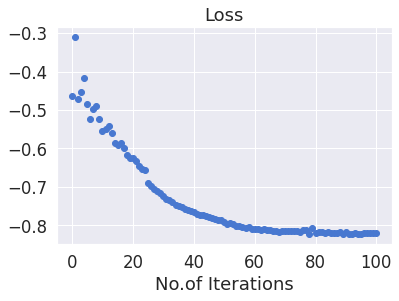

In [2543]:
plt.scatter(list(range(len(Loss))),Loss)
plt.title("Loss")
plt.xlabel("No.of Iterations")
plt.show()

# fashion_tsne = TSNE(random_state=0).fit_transform(Borrower_Emb)
# fashion_scatter(fashion_tsne, training_kmeans.labels_)

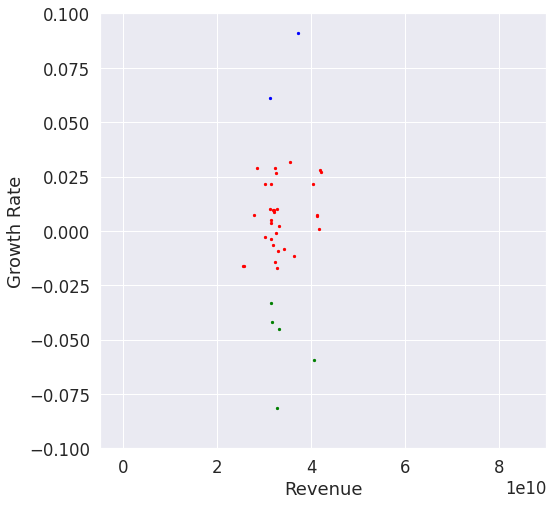

In [2546]:
trained_labels = np.zeros(len(Five_Year_Data_Set_N.items()))
n = 0
for i in Five_Year_Data_Set_N.items():
    ID,data = i
    r = np.mean(np.array(data['Revenue'][6:]))
    gr = np.mean(np.array(data['GR'][6:]))
    
    
    if gr > 0.05:                                              # gr > 0.2, 0.05 < gr < 0.2
        trained_labels[n] = 0
    elif -0.025 < gr < 0.05:
        trained_labels[n] = 1
    else:
        trained_labels[n] = 2
             
    n += 1
        
training_kmeans.labels_ = trained_labels

Rev = T.mean(R_Att[1:,6:],1,True)[np.where(training_kmeans.labels_ == 0)[0]]
Net = T.mean(G_Att[1:,6:],1,True)[np.where(training_kmeans.labels_ == 0)[0]]


Rev2 = T.mean(R_Att[1:,6:],1,True)[np.where(training_kmeans.labels_ == 1)[0]]
Net2 = T.mean(G_Att[1:,6:],1,True)[np.where(training_kmeans.labels_ == 1)[0]]


Rev3 = T.mean(R_Att[1:,6:],1,True)[np.where(training_kmeans.labels_ == 2)[0]]
Net3 = T.mean(G_Att[1:,6:],1,True)[np.where(training_kmeans.labels_ == 2)[0]]



plt.figure(figsize = (8,8))
rev_s = 50000000000
plt.scatter(Rev*rev_s,Net,s = 5,c = np.array(['blue']))
plt.scatter(Rev2*rev_s,Net2, s= 5, c = np.array(['red']))
plt.scatter(Rev3*rev_s,Net3, s = 5, c = np.array(['green']))

plt.xlim(-0.1*50000000000,1.8*50000000000)
plt.ylim(-0.1,0.1)
plt.ylabel("Growth Rate")
plt.xlabel("Revenue")
plt.show()

In [2547]:
Red = []
Blue = []
Green = []

for i in range(len(training_kmeans.labels_)):
    if training_kmeans.labels_[i] == 0:
        Blue.append(i)
    elif training_kmeans.labels_[i] == 1:
        Red.append(i)
    elif training_kmeans.labels_[i] == 2:
        Green.append(i)


n = 0
m = 0
p = 0
q = 0
r = 0

ID_Green = []
ID_Blue = []
ID_Red = []
for i in Five_Year_Data_Set_N.items():
    ID,data = i
    if n in Blue:
        ID_Blue.append(ID)
        if m < 10:
            m += 1

    if n in Red:
        ID_Red.append(ID)
        if q < 10:
            q += 1

    if n in Green:
        ID_Green.append(ID)
        if r < 5:
            r += 1
            
    n += 1


In [2548]:
def Get_Category_GR_Avg(ID_Green,ID_Red,ID_Blue,Scenario_Data_Dict_Demo):
    
    Green = np.zeros(11)
    Red = np.zeros(11)
    Blue = np.zeros(11)
    
    sector_gr_avg = np.zeros(11)
    n = 0
    for i in Scenario_Data_Dict_Demo.items():
        ID,data = i
        sector_gr_avg += np.array(data['GR'])
        n += 1
        
    sector_avg_gr = np.round((sector_gr_avg/len(Scenario_Data_Dict_Demo.items())),3)
    
    m = 0
    p = 0
    r = 0

    for i in Scenario_Data_Dict_Demo.items():
        ID,data = i
        if ID in ID_Green:
            Green += np.array(data['GR'])
            m += 1
        if ID in ID_Blue:
            Blue += np.array(data['GR'])
            p += 1
        if ID in ID_Red:
            Red += np.array(data['GR'])
            r += 1
            
    print("red ",r," green ",m," blue ",p)
            
            
    return (np.round_(Green/m,4)), (np.round_(Blue/p,4)), (np.round_(Red/r,4)),sector_avg_gr

Green_Rev,Blue_Rev,Red_Rev,sector_avg_gr = Get_Category_GR_Avg(ID_Green,ID_Red,ID_Blue,Five_Year_Data_Set_N)

Category_GR_Data_Dict = {'Sector' : Scenario_Data_Dict['Scenario'],
                     'Sector_GR' : sector_avg_gr,
                     'Green' : Green_Rev,
                     'Blue' : Blue_Rev,
                     'Red' : Red_Rev}
print(Category_GR_Data_Dict)

red  32  green  5  blue  2
{'Sector': ['511210'], 'Sector_GR': array([-0.101,  0.024,  0.018, -0.038,  0.049,  0.071, -0.033, -0.014,
        0.035,  0.03 , -0.005]), 'Green': array([-0.1836, -0.021 ,  0.0276, -0.111 ,  0.0588,  0.085 , -0.0946,
       -0.0882,  0.0174, -0.    , -0.096 ]), 'Blue': array([-0.139 ,  0.185 ,  0.0205, -0.082 ,  0.084 ,  0.132 ,  0.0695,
        0.107 ,  0.022 ,  0.0255,  0.156 ]), 'Red': array([-0.0861,  0.021 ,  0.0163, -0.0233,  0.0455,  0.0646, -0.0298,
       -0.0104,  0.0383,  0.0351, -0.0003])}


In [2549]:
# Category_GR_Data_Dict['Sector_GR'][-1] = -0.33

In [2550]:
# Sn, = plt.plot(range(len(Category_GR_Data_Dict['Sector_GR'])),Category_GR_Data_Dict['Sector_GR'],'k')
# ps1n, = plt.plot(range(len(Category_GR_Data_Dict['Green'])),Category_GR_Data_Dict['Green'],'g')
# ps2n, = plt.plot(range(len(Category_GR_Data_Dict['Blue'])),Category_GR_Data_Dict['Blue'],'b')
# ps4n, = plt.plot(range(len(Category_GR_Data_Dict['Red'])),Category_GR_Data_Dict['Red'],'r')
# plt.title( " Sector GR")
# plt.xlabel("Years")

# plt.ylabel("Growth Rate")
# plt.ylim(-0.5,0.5)
# plt.show()

In [2551]:
def Compute_the_Category_Level_Forecast(Category_GR_Data_Dict):
    
    Category_Forecast_Dict = {'Sector_GR' : Category_GR_Data_Dict['Sector_GR']} 
    
    sector_curve = Category_GR_Data_Dict['Sector_GR']
    
    for cat in ['Green', 'Blue', 'Red']:
        
        Category_Forecast_Dict[cat] = list(Category_GR_Data_Dict[cat][:10])
        category_curve = Category_Forecast_Dict[cat]
        
        Forecast = []
        for j in range(len(sector_curve[10:])):
            corr = int(round(np.corrcoef(sector_curve[:10+j],category_curve)[0][1],4)*10000)


            low_limit = round(category_curve[-1] - 0.3,4)

            up_limit = round(category_curve[-1] + 0.3,4)


            Forecast = []
            for k in np.arange(low_limit, up_limit, 0.0001):
                rev = np.append(category_curve,k)
                new_corr = int(round(np.corrcoef(sector_curve[:11+j],rev)[0][1],4)*10000)
                
#                 if cat == 'Blue':
#                     print('C',corr,new_corr,'k',round(k,4))
                    

                if new_corr in range(corr - 100,corr + 100):
#                     if cat == 'Blue':
#                         print("Yes!")
                    if [round(abs(new_corr - corr) + abs(k - category_curve[-1]),4),round(k,5)] not in Forecast:
                        Forecast.append([round(abs(new_corr - corr) + abs(k - sector_curve[-1]),4),round(k,5)])

            try:
                Forecast = np.array(Forecast)
                Forecast = Forecast[Forecast[:,0].argsort()]
                forecast = Forecast[0][1]
            except:
                if sector_curve[9+j] < sector_curve[10+j]:
                    forecast = up_limit
                else:
                    forecast = low_limit
            

            Category_Forecast_Dict[cat].append(forecast)
            
    return Category_Forecast_Dict
    
Category_Level_Forecast_Dict = Compute_the_Category_Level_Forecast(Category_GR_Data_Dict)
print(Category_Level_Forecast_Dict)

{'Sector_GR': array([-0.101,  0.024,  0.018, -0.038,  0.049,  0.071, -0.033, -0.014,
        0.035,  0.03 , -0.005]), 'Green': [-0.1836, -0.021, 0.0276, -0.111, 0.0588, 0.085, -0.0946, -0.0882, 0.0174, -0.0, -0.042], 'Blue': [-0.139, 0.185, 0.0205, -0.082, 0.084, 0.132, 0.0695, 0.107, 0.022, 0.0255, 0.0001], 'Red': [-0.0861, 0.021, 0.0163, -0.0233, 0.0455, 0.0646, -0.0298, -0.0104, 0.0383, 0.0351, -0.0024]}


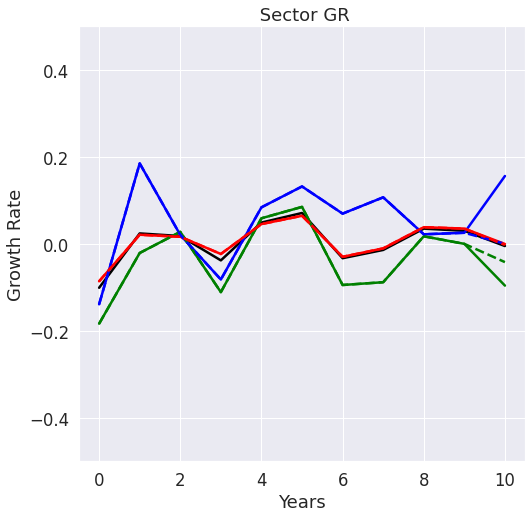

In [2552]:
plt.figure(figsize = (8,8))

Sn, = plt.plot(range(len(Category_GR_Data_Dict['Sector_GR'])),Category_GR_Data_Dict['Sector_GR'],'k')
ps1n, = plt.plot(range(len(Category_GR_Data_Dict['Green'])),Category_GR_Data_Dict['Green'],'g')
ps2n, = plt.plot(range(len(Category_GR_Data_Dict['Blue'])),Category_GR_Data_Dict['Blue'],'b')
ps4n, = plt.plot(range(len(Category_GR_Data_Dict['Red'])),Category_GR_Data_Dict['Red'],'r')


ps1, = plt.plot(range(len(Category_Level_Forecast_Dict['Green'])),Category_Level_Forecast_Dict['Green'],'g--')
ps2, = plt.plot(range(len(Category_Level_Forecast_Dict['Blue'])),Category_Level_Forecast_Dict['Blue'],'b--')
ps4, = plt.plot(range(len(Category_Level_Forecast_Dict['Red'])),Category_Level_Forecast_Dict['Red'],'r--')
plt.title( " Sector GR")
plt.xlabel("Years")

plt.ylabel("Growth Rate")
plt.ylim(-0.5,0.5)
plt.show()

In [2553]:
def Back_Test_Category_Level_Sector(Five_Year_Data_Set_N, Category_Level_Forecast_Dict, ID_Green,ID_Blue,ID_Red):
    
    return_Dict = {}
    sector_curve = Category_Level_Forecast_Dict['Sector_GR']
    error_category = 0
    error_sector = 0
    n = 0
    for i in Five_Year_Data_Set_N.items():
        ID,data = i
        return_Dict[ID] = {'category_error' : [],'sector_error' : []}

        if ID in ID_Green:
            category_curve = Category_Level_Forecast_Dict['Green']
            return_Dict[ID]['Category'] = 'Green'
        elif ID in ID_Blue:
            category_curve = Category_Level_Forecast_Dict['Blue']
            return_Dict[ID]['Category'] = 'Blue'
        elif ID in ID_Red:
            category_curve = Category_Level_Forecast_Dict['Red']
            return_Dict[ID]['Category'] = 'Red'

            
        error_c = 0
        error_s = 0
        for j in range(len(category_curve[10:])):
            
            if data['GR'][10+j] == 0.0:
                val = 0.01
            else:
                val = data['GR'][10+j]
            
            error_c += abs(val - category_curve[10+j])
            error_s += abs(val - sector_curve[10+j])

#             if ID in ID_Green:
#                 print(10+j, return_Dict[ID]['Category'])
#                 print("Company ",data['GR'],"Category ",category_curve,"Sector ", sector_curve)
#                 print("Company ",data['GR'][10+j],"Category ",category_curve[10+j],"Sector ", sector_curve[10+j])
#                 print("Category_Error ",abs(val - category_curve[10+j])/abs(val),"Sector Error ",abs(val - sector_curve[10+j])/abs(val))
#                 print("\n")
                
            return_Dict[ID]['category_error'].append(round(abs(val - category_curve[10+j]),4))
            return_Dict[ID]['sector_error'].append(round(abs(val - sector_curve[10+j]),4))
            
            
        error_category += round(error_c/len(category_curve[10:]),4)
        error_sector += round(error_s/len(category_curve[10:]),4)
        
        n += 1
            
    error_category = round(error_category/n,4)
    error_sector = round(error_sector/n,4)
        
    print('category_curve_error ',error_category,'sector_curve_error ',error_sector)
    
    return return_Dict

#Category_GR_Data_Dict  #Category_Level_Forecast_Dict
Error_Dict = Back_Test_Category_Level_Sector(Five_Year_Data_Set_N, Category_GR_Data_Dict, ID_Green,ID_Blue,ID_Red)

category_curve_error  0.0472 sector_curve_error  0.0491


59 59


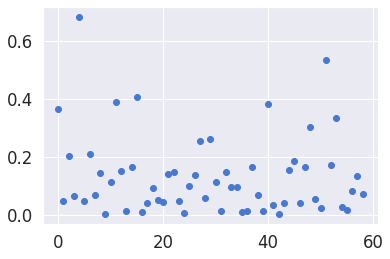

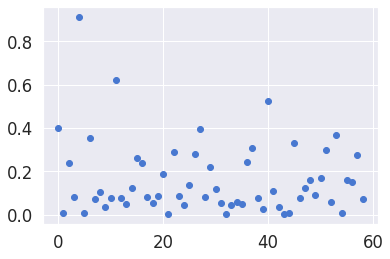

Error Sector  0.1636271186440678
Error Green  0.14419999999999994 Error Red  0.09394615384615385 Error Blue  0.21848000000000006


In [2528]:
def Analyse_Error_Dict(Dict):
    
    
    C = []
    S = []
    
    r = 0
    g = 0
    b = 0
    error_red = 0
    error_green = 0
    error_blue = 0
    error_s = 0
    for i in Dict.items():
        ID,data = i
        
        C.append(sum(data['category_error'])/len(data['category_error']))
            
        S.append(sum(data['sector_error'])/len(data['sector_error']))

        
        
        if data['Category'] == 'Green':
            error_green += sum(data['category_error'])/len(data['category_error'])
            g += 1
        elif data['Category'] == 'Red':
            error_red += sum(data['category_error'])/len(data['category_error'])
            r += 1
        elif data['Category'] == 'Blue':
            error_blue += sum(data['category_error'])/len(data['category_error'])
            b += 1
            
            
            
        error_s += sum(data['sector_error'])/len(data['sector_error'])
        
#     C.sort()
#     S.sort()
    print(len(C),len(S))
    
    fit_c = stats.norm.pdf(C, np.mean(C), np.std(C))
    fit_s = stats.norm.pdf(S, np.mean(S), np.std(S))
    
    plt.scatter(np.arange(len(C)),C)
    plt.show()
    plt.scatter(np.arange(len(S)),S)
    plt.show()
        
    error_green = error_green/g
    error_red = error_red/r
    error_blue = error_blue/b
    
    error_s = error_s/len(Dict.items())

    
    print("Error Sector ",error_s)
    print("Error Green ",error_green, "Error Red ",error_red,"Error Blue ", error_blue)
        
        
        
Analyse_Error_Dict(Error_Dict)    

In [2002]:
    Bar_Dict = {"0-0.5" : 0,"0.5-1" : 0, "1-1.5" : 0, "1.5-2" : 0, "2-2.5" : 0}
    S_Bar_Dict = {"0-0.5" : 0,"0.5-1" : 0, "1-1.5" : 0, "1.5-2" : 0, "2-2.5" : 0}

#         if 0 < sum(data['category_error'])/len(data['category_error']) < 0.5:
#             Bar_Dict["0-0.5"] += 1
#         elif 0.5 < sum(data['category_error'])/len(data['category_error']) < 1:
#             Bar_Dict["0.5-1"] += 1
#         elif 1 < sum(data['category_error'])/len(data['category_error']) < 1.5:
#             Bar_Dict["1-1.5"] += 1
#         elif 1.5 < sum(data['category_error'])/len(data['category_error']) < 2:
#             Bar_Dict["1.5-2"] += 1
#         elif 2 < sum(data['category_error'])/len(data['category_error']) < 2.5:

#     print("Category Error Distribution")
#     plt.bar(Bar_Dict.keys(),Bar_Dict.values())
#     plt.show()
#     print("Sector Error Distribution")
#     plt.bar(S_Bar_Dict.keys(),S_Bar_Dict.values())
#     plt.show()

In [ ]:
def Compute_the_Borrower_Level_Forecast_with_C_and_S(Five_Year_Data_Set_N,Category_GR_Data_Dict, ID_Green,ID_Blue,ID_Red):
    
    return_Dict = {}
    n = 0
    for i in Five_Year_Data_Set_N.items():
        ID,data = i
        print(n,ID)
#         if ID == 'a277f30d-f93f-5edf-983e-fd017e365f92':
#             print(data['GR'])
        return_Dict[ID] = {'GR' : data['GR']}

        if ID in ID_Green:
            category_curve = Category_GR_Data_Dict['Green']
        elif ID in ID_Blue:
            category_curve = Category_GR_Data_Dict['Blue']
        elif ID in ID_Red:
            category_curve = Category_GR_Data_Dict['Red']

        C_GR_Forecast = []
        for j in range(len(category_curve[6:])):
            entity_curve = data['GR'][:6+j]
            corr = int(round(np.corrcoef(category_curve[:6+j],entity_curve)[0][1],4)*10000)


            low_limit = round(entity_curve[-1] - 8,4)

            up_limit = round(entity_curve[-1] + 8.5,4)


            Forecast = []
            for k in np.arange(low_limit, up_limit, 0.001):
                rev = np.append(entity_curve,k)
                new_corr = int(round(np.corrcoef(category_curve[:7+j],rev)[0][1],4)*10000)
                #print('C',corr,new_corr,'k',round(k,4))

                if new_corr in range(corr - 100,corr + 100):
#                     print('C',corr,new_corr,'k',round(k,4))
#                     print("Yes!")
                    if [round(abs(new_corr - corr) + abs(k - entity_curve[-1]),4),round(k,5)] not in Forecast:
                        Forecast.append([round(abs(new_corr - corr) + abs(k - entity_curve[-1]),4),round(k,5)])
            #C
            Forecast = np.array(Forecast)
            Forecast = Forecast[Forecast[:,0].argsort()]

            forecast = Forecast[0][1]

            C_GR_Forecast.append(forecast)


        S_GR_Forecast = []
        for j in range(len(Category_GR_Data_Dict['Sector_GR'][6:])):
            entity_curve = data['GR'][:6+j]
            corr = int(round(np.corrcoef(Category_GR_Data_Dict['Sector_GR'][:6+j],entity_curve)[0][1],4)*10000)


            low_limit = round(entity_curve[-1] - 8,4)

            up_limit = round(entity_curve[-1] + 8.5,4)


            Forecast = []
            for k in np.arange(low_limit, up_limit, 0.001):
                rev = np.append(entity_curve,k)
                new_corr = int(round(np.corrcoef(Category_GR_Data_Dict['Sector_GR'][:7+j],rev)[0][1],4)*10000)
    #                     print('S',corr,new_corr,'k',round(k,4))
                if new_corr in range(corr - 100,corr + 100):
#                     print('S',corr,new_corr,'k',round(k,4))
#                     print("Yes!")
                    if [round(abs(new_corr - corr) + abs(k - entity_curve[-1]),4),round(k,5)] not in Forecast:
                        Forecast.append([round(abs(new_corr - corr) + abs(k - entity_curve[-1]),4),round(k,5)])
            #S
            Forecast = np.array(Forecast)
            Forecast = Forecast[Forecast[:,0].argsort()]

            forecast = Forecast[0][1]

            S_GR_Forecast.append(forecast)
        n += 1

        return_Dict[ID]['His+Category_Forecast'] = data['GR'][:6] + C_GR_Forecast
        return_Dict[ID]['His+Sector_Forecast'] = data['GR'][:6] + S_GR_Forecast
        
        
    return return_Dict    
            
Forecast_Sector_Dict = Compute_the_Borrower_Level_Forecast_with_C_and_S(Five_Year_Data_Set_N,Category_GR_Data_Dict, ID_Green,ID_Blue,ID_Red)

In [2503]:
def Back_Test_Borrower_Level_Sector(Compute_the_Forecast_with_C_and_S):
    
    n = 0
    c_error = 0
    s_error = 0
    for i in Compute_the_Forecast_with_C_and_S.items():
        ID,data = i
        #print(ID)
        array = np.array(data['GR']).copy()
        array_category = abs(array - np.array(data['His+Category_Forecast']))
        array_sector = abs(array - np.array(data['His+Sector_Forecast']))
#         print(array[6:])
#         print(array_category[6:],array_sector[6:])
        
        category_curve_error = 0
        sector_curve_error = 0
        array[array == 0] = 0.01
        for j in range(len(array[6:])):
            category_curve_error += array_category[6+j]/abs(array[6+j])
            sector_curve_error += array_sector[6+j]/abs(array[6+j])
        c_error += category_curve_error/len(array[6:])
        s_error += sector_curve_error/len(array[6:])
        
#         print(c_error)
#         print(s_error)
        n += 1
              
    
    category_curve_error = c_error/n
    sector_curve_error = s_error/n
    print('category_curve_error ',category_curve_error,'sector_curve_error ',sector_curve_error)

Back_Test_Borrower_Level_Sector(Other_Sector_Dict)

category_curve_error  4.802330750688848 sector_curve_error  4.0915819770238295


In [2457]:
Software_Sector_Dict #= Forecast_Sector_Dict.copy()

In [2502]:
Other_Sector_Dict #= Forecast_Sector_Dict.copy()

In [1882]:
def Get_the_GR_Forecast(Sector_Data_Dict,sector_forecast):
        
#     Sector_Data_Dict_New = {}
#     Sector_Data_Dict_New['Sector'] = Sector_Data_Dict['Sector']
#     Sector_Data_Dict_New['Sector_GR'] = Sector_Data_Dict['Sector_GR']
    for g in sector_forecast:
        print("Year")
        n = 0
        Rev_Forecast = {}
        for i in Sector_Data_Dict.items():
            if n > 1:
                ID,data = i
#                 print(ID,data)
                print(Sector_Data_Dict['Sector_GR'],data)
                corr = round(np.corrcoef(Sector_Data_Dict['Sector_GR'],data)[0][1],4)
#                 print("Corr :", corr)

                if data[-1] - 3 <= -3:
                    low_limit = -3
                else:
                    low_limit = round(data[-1] - 4,4)

                if data[-1] + 0.3 >= 3:
                    up_limit = 3
                else:
                    up_limit = round(data[-1] + 0.3,4)
                    
#                 print("ll :",low_limit,"ul: ",up_limit)

                Rev_Forecast[ID] = []
                sector_forecast = g
                sector_rev = np.append(Sector_Data_Dict['Sector_GR'],sector_forecast)
                for j in np.arange(low_limit, up_limit, 0.0001):
                    rev = np.append(data,j)
                    new_corr = round(np.corrcoef(sector_rev,rev)[0][1],4)
#                     print(corr*1000,new_corr*1000,'j',round(j,4))
                    if new_corr*1000 in range(int(corr*1000) - 40,int(corr*1000) + 40):
#                         print(corr*1000,new_corr*1000,'j',round(j,4))
#                         print("Yes!")
                        if [round(abs(corr-new_corr),4),round(j,5)] not in Rev_Forecast[ID]:
#                             print("Appended")
                            Rev_Forecast[ID].append([round(abs(new_corr - corr) + abs(j - data[-1]),4),round(j,5)])

            n += 1
        
        
        for i in Rev_Forecast.items():
            ID,val  = i
            val = np.array(val)
#             print("Val :",val)
            val = val[val[:,0].argsort()]

            Sector_Data_Dict[ID] = np.append(Sector_Data_Dict[ID],[val[0][1]])
        
        Sector_Data_Dict['Sector_GR'] = np.append(Sector_Data_Dict['Sector_GR'],round(sector_forecast,5))

        
    return Sector_Data_Dict
    
Forecasted_GR = Get_the_GR_Forecast(Category_GR_Data_Dict,[0.011,0.018,0.018,0.018])
for i in Forecasted_GR.items():
    print(i)



Year
[0.509 0.434 0.274 0.347 0.314] [1.4755 1.0668 0.6621 0.3373 0.9415]
[0.509 0.434 0.274 0.347 0.314] [0.1335 0.1967 0.1288 0.3813 0.0687]
Year
[0.509 0.434 0.274 0.347 0.314 0.011] [1.4755 1.0668 0.6621 0.3373 0.9415 0.4364]
[0.509 0.434 0.274 0.347 0.314 0.011] [0.1335 0.1967 0.1288 0.3813 0.0687 0.1759]
Year
[0.509 0.434 0.274 0.347 0.314 0.011 0.018] [1.4755 1.0668 0.6621 0.3373 0.9415 0.4364 0.4368]
[0.509 0.434 0.274 0.347 0.314 0.011 0.018] [0.1335 0.1967 0.1288 0.3813 0.0687 0.1759 0.1778]
Year
[0.509 0.434 0.274 0.347 0.314 0.011 0.018 0.018] [1.4755 1.0668 0.6621 0.3373 0.9415 0.4364 0.4368 0.4358]
[0.509 0.434 0.274 0.347 0.314 0.011 0.018 0.018] [0.1335 0.1967 0.1288 0.3813 0.0687 0.1759 0.1778 0.1784]
('Sector', ['325412'])
('Sector_GR', array([0.509, 0.434, 0.274, 0.347, 0.314, 0.011, 0.018, 0.018, 0.018]))
('Green', array([1.4755, 1.0668, 0.6621, 0.3373, 0.9415, 0.4364, 0.4368, 0.4358,
       0.4375]))
('Red', array([0.1335, 0.1967, 0.1288, 0.3813, 0.0687, 0.1759, 0.

In [1883]:
for i in Forecasted_GR.items():
    print(i)

('Sector', ['325412'])
('Sector_GR', array([0.509, 0.434, 0.274, 0.347, 0.314, 0.011, 0.018, 0.018, 0.018]))
('Green', array([1.4755, 1.0668, 0.6621, 0.3373, 0.9415, 0.4364, 0.4368, 0.4358,
       0.4375]))
('Red', array([0.1335, 0.1967, 0.1288, 0.3813, 0.0687, 0.1759, 0.1778, 0.1784,
       0.1786]))


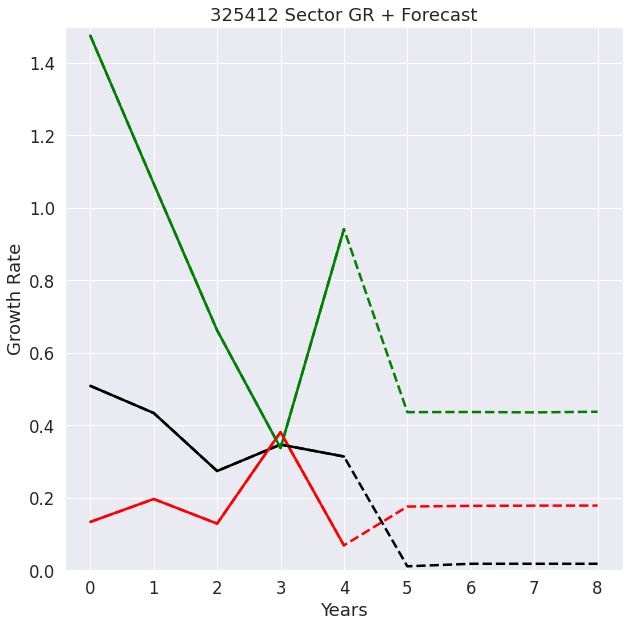

In [1884]:
scale = 1
plt.figure(figsize = (10,10))
S, = plt.plot(range(len(Forecasted_GR['Sector_GR'][0:5])),Forecasted_GR['Sector_GR'][0:5]*scale,'k')
ps1, = plt.plot(range(len(Forecasted_GR['Green'][0:5])),Forecasted_GR['Green'][0:5]*scale,'g')
#ps2, = plt.plot(range(len(Forecasted_GR['Blue'][0:5])),Forecasted_GR['Blue'][0:5]*scale,'b')
#ps3, = plt.plot(range(len(Forecasted_GR['Magenta'][0:5])),Forecasted_GR['Magenta'][0:5]*scale,'m')
ps4, = plt.plot(range(len(Forecasted_GR['Red'][0:5])),Forecasted_GR['Red'][0:5]*scale,'r')

Sn, = plt.plot(range(len(Forecasted_GR['Sector_GR'])),Forecasted_GR['Sector_GR']*scale,'k--')
ps1n, = plt.plot(range(len(Forecasted_GR['Green'])),Forecasted_GR['Green']*scale,'g--')
#ps2n, = plt.plot(range(len(Forecasted_GR['Blue'])),Forecasted_GR['Blue']*scale,'b--')
#ps3n, = plt.plot(range(len(Forecasted_GR['Magenta'])),Forecasted_GR['Magenta']*scale,'m--')
ps4n, = plt.plot(range(len(Forecasted_GR['Red'])),Forecasted_GR['Red']*scale,'r--')
plt.title(Category_GR_Data_Dict['Sector'][0] + " Sector GR + Forecast")
plt.xlabel("Years")

plt.ylabel("Growth Rate")
plt.ylim(-0.0,1.5)
plt.show()

In [767]:
def Get_Category_Rev_Avg(ID_Green,ID_Red,ID_Blue,ID_Magenta,Scenario_Data_Dict_Demo):
    
    Green = np.array([0.,0.,0.,0.,0.])
    Red = np.array([0.,0.,0.,0.,0.])
    Blue = np.array([0.,0.,0.,0.,0.])
    Magenta = np.array([0.,0.,0.,0.,0.])
    
    m = p = q = r = 0

    for i in Scenario_Data_Dict_Demo.items():
        ID,data = i
        if ID in ID_Green:
            Green += np.array(data['Revenue'])
            m += 1
        if ID in ID_Blue:
            Blue += np.array(data['Revenue'])
            p += 1
        if ID in ID_Magenta:
            Magenta += np.array(data['Revenue'])
            q += 1
        if ID in ID_Red:
            Red += np.array(data['Revenue'])
            r += 1
            
            
    return (np.round_(Green/m,4)), (np.round_(Blue/p,4)), (np.round_(Magenta/q,4)), (np.round_(Red/r,4)) 

Green_Rev,Blue_Rev,Magenta_Rev,Red_Rev = Get_Category_Rev_Avg(ID_Green,ID_Red,ID_Blue,ID_Magenta,Scenario_Data_Dict)

Category_Data_Dict = {'Sector' : Scenario_Data_Dict['Scenario'],
                     'Sector_Rev' : Scenario_Data_Dict['Scenario_Rev'],
                     'Green' : Green_Rev,
                     'Blue' : Blue_Rev,
                     'Magenta' : Magenta_Rev,
                     'Red' : Red_Rev}
print(Category_Data_Dict)

{'Sector': ['2111'], 'Sector_Rev': array([0.19 , 0.203, 0.214, 0.226, 0.228]), 'Green': array([0.1346, 0.159 , 0.1643, 0.1791, 0.1767]), 'Blue': array([0.4777, 0.4945, 0.5101, 0.5243, 0.5331]), 'Magenta': array([0.1189, 0.1522, 0.1606, 0.1708, 0.1747]), 'Red': array([0.0879, 0.0932, 0.1038, 0.1145, 0.115 ])}


In [768]:
def Get_the_Forecast(Sector_Data_Dict):
    
    n = 0
    Rev_Forecast = {}
    for i in Sector_Data_Dict.items():
        if n > 1:
            ID,data = i
            corr = round(np.corrcoef(Sector_Data_Dict['Scenario_Rev'][0:4],data['Revenue'])[0][1],3)
            
            #print(ID,'corr',corr,'data[3]', data['Revenue'][3])

            if data['Revenue'][3] - 0.3 <= 0:
                low_limit = 0
            else:
                low_limit = data['Revenue'][3] - 0.3

            if data['Revenue'][3] + 0.3 >= 1.7:
                up_limit = 1.7
            else:
                up_limit = data['Revenue'][3] + 0.3

            Rev_Forecast[ID] = []
            for j in np.arange(low_limit, up_limit, 0.0001):
                rev = np.append(data['Revenue'],j)
                new_corr = round(np.corrcoef(Sector_Data_Dict['Scenario_Rev'],rev)[0][1],3)
                #print(corr*1000,new_corr*1000,'j',round(j,4))
                if new_corr*1000 in range(int(corr*1000) - 40,int(corr*1000) + 40):
                    #print("Yes!")
                    if [round(abs(corr-new_corr),5),round(j,5)] not in Rev_Forecast[ID]:
                        Rev_Forecast[ID].append([round(abs(new_corr - corr),5),round(j,5),round(corr,5)])

        n += 1
        
        
    return Rev_Forecast
    
#Forecasted_Revenue = Get_the_Forecast(Scenario_Data_Dict)

In [779]:
def Get_Avg_Error(Forecasted_Revenue,Sector_Data_Dict):
    error = 0
    n = 0
    Forecast_Data_Dict = {}
    Forecast_Data_Dict['Sector'] = Sector_Data_Dict['Scenario']
    Forecast_Data_Dict['Sector Revenue'] = Sector_Data_Dict['Scenario_Rev']
    for i in Forecasted_Revenue.items():
        ID,val  = i
        #print(ID)
        Forecast_Data_Dict[ID] = {'Company Revenue':Sector_Data_Dict[ID]['Revenue'],'Actual':[Sector_Data_Dict[ID]['Revenue Forecast']],
                                 'Computed Forecast':[val[0][1]]}
        if Sector_Data_Dict[ID]['Revenue Forecast'] != 0:
            val = np.array(val)
            #print(val)
            val = val[val[:,0].argsort()]
            ind = abs(val - [0,Sector_Data_Dict[ID]['Revenue'][3],0])
            val = val[ind[:,1][:100].argsort()]
            #print(val)
            current_err = round(abs(Sector_Data_Dict[ID]['Revenue Forecast'] - val[0][1])/Sector_Data_Dict[ID]['Revenue Forecast'],5)
            
#             if current_err > 0.25:
#                 print('Sector',Sector_Data_Dict['Scenario'],'Sector Revenue' ,Sector_Data_Dict['Scenario_Rev'],'Correlation ',val[0][2])
#                 print(ID,'Company_Rev ',Sector_Data_Dict[ID]['Revenue'],'R5 ',Sector_Data_Dict[ID]['Revenue Forecast']," Computed ", val[0][1], "Error ",current_err,'\n')

            error += current_err
        else:
            error += abs(0.01 - val[0][1])/0.01
        n += 1

    error = round(error/n,3)

    print(n,"Avg Error ",error)
    
    return error,Forecast_Data_Dict

#avg_error,Forecast_Data_Dict = Get_Avg_Error(Forecasted_Revenue,Scenario_Data_Dict)
    
#print(len(Forecasted_Revenue.items()))

In [778]:
# def Get_the_Forecast_Demo(Sector_Data_Dict,sector_forecast):
        
#     for g in sector_forecast:
#         print("Year")
#         n = 0
#         Rev_Forecast = {}
#         for i in Sector_Data_Dict.items():
#             if n > 1:
#                 ID,data = i
#                 print(Sector_Data_Dict['Sector_Rev'],data)
#                 corr = round(np.corrcoef(Sector_Data_Dict['Sector_Rev'],data)[0][1],4)
                
#                 #print(ID,'corr',corr,'data[3]', data['Revenue'][3])

#                 if data[-1] - 0.3 <= 0:
#                     low_limit = 0
#                 else:
#                     low_limit = data[-1] - 0.3

#                 if data[-1] + 0.3 >= 1.7:
#                     up_limit = 1.7
#                 else:
#                     up_limit = data[-1] + 0.3

#                 Rev_Forecast[ID] = []
#                 sector_forecast = Sector_Data_Dict['Sector_Rev'][-1] + Sector_Data_Dict['Sector_Rev'][-1]*g
#                 sector_rev = np.append(Sector_Data_Dict['Sector_Rev'],sector_forecast)
#                 for j in np.arange(low_limit, up_limit, 0.0001):

#                     rev = np.append(data,j)
#                     new_corr = round(np.corrcoef(sector_rev,rev)[0][1],4)
#                     #print(corr*1000,new_corr*1000,'j',round(j,4))
#                     if new_corr*1000 in range(int(corr*1000) - 40,int(corr*1000) + 40):
#                         #print("Yes!")
#                         if [round(abs(corr-new_corr),4),round(j,4)] not in Rev_Forecast[ID]:
#                             Rev_Forecast[ID].append([round(abs(new_corr - corr) + abs(j - data[-1]),4),round(j,5)])

#             n += 1
        
    
#         Sector_Data_Dict['Sector_Rev'] = np.append(Sector_Data_Dict['Sector_Rev'],round(sector_forecast,4))
#         for i in Rev_Forecast.items():
#             ID,val  = i
#             val = np.array(val)
#             val = val[val[:,0].argsort()]
# #             ind = abs(val - [0,Sector_Data_Dict[ID][-1],0])
# #             val = val[ind[:,1][:150].argsort()]

#             Sector_Data_Dict[ID] = np.append(Sector_Data_Dict[ID],[val[0][1]])

        
#     return Sector_Data_Dict
    
# Forecasted_Revenue = Get_the_Forecast_Demo(Category_Data_Dict,[0.04,0.04,0.04,0.04])
# for i in Forecasted_Revenue.items():
#     print(i)

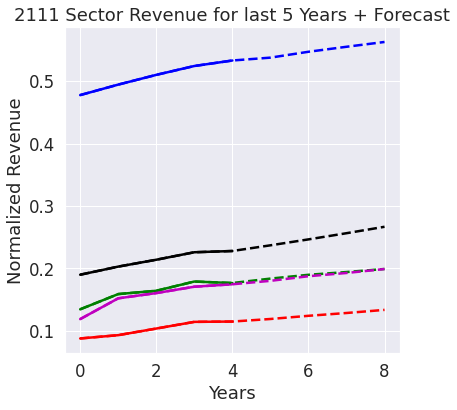

In [771]:
plt.figure(figsize = (6,6))
S, = plt.plot(range(len(Forecasted_Revenue['Sector_Rev'][0:5])),Forecasted_Revenue['Sector_Rev'][0:5],'k')
ps1, = plt.plot(range(len(Forecasted_Revenue['Green'][0:5])),Forecasted_Revenue['Green'][0:5],'g')
ps2, = plt.plot(range(len(Forecasted_Revenue['Blue'][0:5])),Forecasted_Revenue['Blue'][0:5],'b')
ps3, = plt.plot(range(len(Forecasted_Revenue['Magenta'][0:5])),Forecasted_Revenue['Magenta'][0:5],'m')
ps4, = plt.plot(range(len(Forecasted_Revenue['Red'][0:5])),Forecasted_Revenue['Red'][0:5],'r')

Sn, = plt.plot(range(len(Forecasted_Revenue['Sector_Rev'])),Forecasted_Revenue['Sector_Rev'],'k--')
ps1n, = plt.plot(range(len(Forecasted_Revenue['Green'])),Forecasted_Revenue['Green'],'g--')
ps2n, = plt.plot(range(len(Forecasted_Revenue['Blue'])),Forecasted_Revenue['Blue'],'b--')
ps3n, = plt.plot(range(len(Forecasted_Revenue['Magenta'])),Forecasted_Revenue['Magenta'],'m--')
ps4n, = plt.plot(range(len(Forecasted_Revenue['Red'])),Forecasted_Revenue['Red'],'r--')
#plt.legend([S,ps1,ps2,ps3,ps4],[ 'Sector '+str(n_borrowers), 'PS1', 'PS2', 'PS3', 'PS4'])
plt.title(Forecasted_Revenue['Sector'][0] + " Sector Revenue for last 5 Years + Forecast")
plt.xlabel("Years")

plt.ylabel("Normalized Revenue")
plt.show()

In [1256]:
def Get_Sector_Data_Dict(scenario,CapIQ_data_dict_FY_N):
    
    test_dict = {}
    for i in CapIQ_data_dict_FY_N.items():
        ID,data = i
        
        for j in scenario:
            if data['Sector'] == str(j):
                test_dict[ID] = data
            
    sector_rev_avg = np.zeros(11)    
    for i in test_dict.items():
        ID,data = i
        sector_rev_avg += np.array(data['Revenue'])
        
    sector_avg_rev = np.round((sector_rev_avg/len(test_dict.items())),3)
    
    Sector_Data_Dict = {}
    Sector_Data_Dict['Scenario'] = scenario
    Sector_Data_Dict['Scenario_Rev'] = sector_avg_rev

    
    for i in test_dict.items():
        ID,data = i
        if len(set(data['Revenue'][0:5])) != 1:
            Sector_Data_Dict[ID] = {'Revenue' : data['Revenue'],'GR' : data['GR']}
            
    
    return Sector_Data_Dict

Scenario_Data_Dict = Get_Sector_Data_Dict([sector],Six_Year_Data_Dict_withGR_N)
    
m = 0
for i in Scenario_Data_Dict.items():
    print(i)
    if m > 3:
        break
    m += 1
print(len(Scenario_Data_Dict.items()))

('Scenario', ['511210'])
('Scenario_Rev', array([0.338, 0.353, 0.364, 0.369, 0.379, 0.382, 0.389, 0.396, 0.404,
       0.408, 0.413]))
('01937277-8afb-5f5a-8820-b81e0219776b', {'Revenue': [0.54, 0.623, 0.623, 0.565, 0.624, 0.647, 0.622, 0.628, 0.636, 0.636, 0.653], 'GR': [-0.01, 0.653, -0.01, -0.01, 0.471, 0.935, -0.01, 0.305, 0.259, 0.01, 0.488]})
('05246f08-ae8f-56a9-a76f-3002d7608125', {'Revenue': [0.627, 0.628, 0.631, 0.635, 0.639, 0.641, 0.645, 0.648, 0.654, 0.662, 0.667], 'GR': [0.017, 0.015, 0.112, 0.144, 0.117, 0.049, 0.09, 0.08, 0.125, 0.145, 0.077]})
('0a126eec-6b7c-55f1-ba4a-ad9a9e221116', {'Revenue': [0.098, 0.112, 0.107, 0.134, 0.153, 0.144, 0.136, 0.122, 0.137, 0.221, 0.227], 'GR': [0.188, 0.136, -0.01, 0.252, 0.144, -0.01, -0.01, -0.01, 0.125, 0.498, 0.328]})
60
